# Water Quality Prediction Models 

## Model 1: Stacked LSTM for Turbidity Prediction (Deep Learning / Time Series)
- **Architecture:** LSTM(128) → Dropout(0.2) → LSTM(64) → Dropout(0.2) → Dense(32, ReLU) → Dense(1, Linear)
- **Input:** 24-hour lookback window, 19 features (sensor readings + lags + rolling stats + temporal encodings)
- **Target:** Turbidity 12 hours ahead (log-transformed)
- **Loss:** Huber loss (robust to outliers)

## Model 2: Random Forest Classifier for Water Quality Status
- **Input:** 11 engineered features (sensor readings + temporal encodings + rolling statistics)
- **Target:** Water Quality Status (Safe / Warning / Unsafe)
- **Validation:** 5-Fold Stratified Cross-Validation

##  Imports & Setup

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, confusion_matrix, accuracy_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


##  Load & Explore Data

In [3]:
df = pd.read_csv('water_quality_processed.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
print(f"Stations: {df['Station'].nunique()}")
print(f"\nColumn list:\n{list(df.columns)}")

Dataset shape: (295754, 41)
Date range: 2016-03-01 00:00:00 to 2020-04-01 23:00:00
Stations: 11

Column list:
['Timestamp', 'Conductivity', 'NO3', 'Temp', 'Turbidity', 'Dayofweek', 'Month', 'Station', 'Q', 'Level', 'Hour', 'Quality_Status', 'Year', 'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'IsWeekend', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'Turbidity_lag_1h', 'Turbidity_lag_6h', 'Turbidity_lag_12h', 'Turbidity_lag_24h', 'Conductivity_lag_1h', 'Conductivity_lag_6h', 'Conductivity_lag_12h', 'Conductivity_lag_24h', 'Turbidity_rolling_mean_6h', 'Turbidity_rolling_std_6h', 'Turbidity_rolling_mean_12h', 'Turbidity_rolling_std_12h', 'Turbidity_rolling_mean_24h', 'Turbidity_rolling_std_24h', 'Conductivity_rolling_mean_6h', 'Conductivity_rolling_std_6h', 'Conductivity_rolling_mean_12h', 'Conductivity_rolling_std_12h', 'Conductivity_rolling_mean_24h', 'Conductivity_rolling_std_24h']


In [4]:
print("Quality Status distribution:")
print(df['Quality_Status'].value_counts())
print(f"\nMissing values in key columns:")
print(f"  Turbidity:    {df['Turbidity'].isnull().sum():>6} ({df['Turbidity'].isnull().mean()*100:.1f}%)")
print(f"  Conductivity: {df['Conductivity'].isnull().sum():>6} ({df['Conductivity'].isnull().mean()*100:.1f}%)")
print(f"  Temp:         {df['Temp'].isnull().sum():>6} ({df['Temp'].isnull().mean()*100:.1f}%)")
print(f"\nTurbidity statistics (before log transform):")
print(df['Turbidity'].describe())

Quality Status distribution:
Quality_Status
Safe       197350
Warning     68635
Unsafe      29769
Name: count, dtype: int64

Missing values in key columns:
  Turbidity:    133411 (45.1%)
  Conductivity: 133843 (45.3%)
  Temp:         173087 (58.5%)

Turbidity statistics (before log transform):
count    162343.000000
mean         27.584179
std          56.686639
min           0.000000
25%           2.990000
50%           5.640000
75%          19.593333
max        1093.210000
Name: Turbidity, dtype: float64


---
##  Model 1:  LSTM for Turbidity Prediction

### Data Preprocessing and Model Architecture:
1. **19 input features** — sensor readings, lag features, rolling statistics, temporal encodings
2. **Log-transform** on turbidity to handle extreme right skew
3. **Larger model** — LSTM(128) → LSTM(64) → Dense(32)
4. **Reduced lookback** to 24h — lag features already encode history
5. **12-hour forecast horizon** — turbidity prediction
6. **Huber loss** — robust to outlier spikes, better than MSE for skewed targets

###  Data Preparation

In [5]:
# 19 input features
FEATURES = [
    'Turbidity', 'Conductivity', 'Temp',
    'Turbidity_lag_1h', 'Turbidity_lag_6h', 'Turbidity_lag_12h', 'Turbidity_lag_24h',
    'Conductivity_lag_1h', 'Conductivity_lag_6h',
    'Turbidity_rolling_mean_6h', 'Turbidity_rolling_std_6h',
    'Turbidity_rolling_mean_12h', 'Turbidity_rolling_std_12h',
    'Turbidity_rolling_mean_24h', 'Turbidity_rolling_std_24h',
    'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos'
]

print(f"Using {len(FEATURES)} input features:")
for i, f in enumerate(FEATURES, 1):
    print(f"  {i:2d}. {f}")

# Select best station
station_counts = df.dropna(subset=FEATURES).groupby('Station').size()
best_station = station_counts.idxmax()
print(f"\nSelected station: {best_station} ({station_counts[best_station]} complete records)")

# Filter and clean
lstm_df = df[df['Station'] == best_station][['Timestamp'] + FEATURES].copy()
lstm_df = lstm_df.sort_values('Timestamp').reset_index(drop=True)
lstm_df = lstm_df.dropna(subset=FEATURES).reset_index(drop=True)
print(f"Records after dropping nulls: {len(lstm_df)}")
print(f"Date range: {lstm_df['Timestamp'].min()} to {lstm_df['Timestamp'].max()}")

Using 19 input features:
   1. Turbidity
   2. Conductivity
   3. Temp
   4. Turbidity_lag_1h
   5. Turbidity_lag_6h
   6. Turbidity_lag_12h
   7. Turbidity_lag_24h
   8. Conductivity_lag_1h
   9. Conductivity_lag_6h
  10. Turbidity_rolling_mean_6h
  11. Turbidity_rolling_std_6h
  12. Turbidity_rolling_mean_12h
  13. Turbidity_rolling_std_12h
  14. Turbidity_rolling_mean_24h
  15. Turbidity_rolling_std_24h
  16. Hour_sin
  17. Hour_cos
  18. Month_sin
  19. Month_cos

Selected station: Sandy Ck Homebush (27510 complete records)
Records after dropping nulls: 27510
Date range: 2016-12-06 18:00:00 to 2020-04-01 23:00:00


### Log-Transform Turbidity

Applying log1p transform to: ['Turbidity', 'Turbidity_lag_1h', 'Turbidity_lag_6h', 'Turbidity_lag_12h', 'Turbidity_lag_24h', 'Turbidity_rolling_mean_6h', 'Turbidity_rolling_std_6h', 'Turbidity_rolling_mean_12h', 'Turbidity_rolling_std_12h', 'Turbidity_rolling_mean_24h', 'Turbidity_rolling_std_24h']


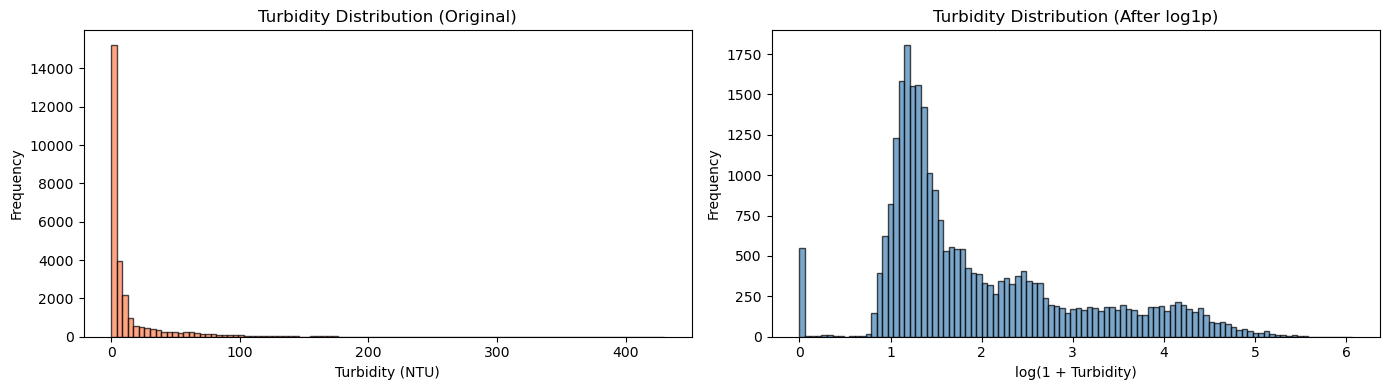

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(lstm_df['Turbidity'], bins=100, edgecolor='black', alpha=0.7, color='coral')
axes[0].set_title('Turbidity Distribution (Original)', fontsize=12)
axes[0].set_xlabel('Turbidity (NTU)')
axes[0].set_ylabel('Frequency')

# Apply log1p transform to all turbidity-related columns
turb_cols = [c for c in FEATURES if 'Turbidity' in c]
print(f"Applying log1p transform to: {turb_cols}")
for col in turb_cols:
    lstm_df[col] = np.log1p(lstm_df[col])

axes[1].hist(lstm_df['Turbidity'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_title('Turbidity Distribution (After log1p)', fontsize=12)
axes[1].set_xlabel('log(1 + Turbidity)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('turbidity_log_transform.png', dpi=150, bbox_inches='tight')
plt.show()

### Feature Scaling & Sequence Creation

In [7]:
LOOKBACK = 24   # 24-hour lookback window
HORIZON = 12    # Predict 12 hours ahead (reduced from 24 for better accuracy)

print(f"Lookback: {LOOKBACK} hours")
print(f"Forecast horizon: {HORIZON} hours ahead")

# Scale features to [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(lstm_df[FEATURES].values)

# Separate scaler for inverse-transforming turbidity predictions (log-space)
target_scaler = MinMaxScaler()
target_scaler.fit(lstm_df[['Turbidity']].values)

def create_sequences(data, lookback, horizon):
    """Create input sequences and targets for LSTM."""
    X, y = [], []
    for i in range(lookback, len(data) - horizon):
        X.append(data[i - lookback:i, :])
        y.append(data[i + horizon - 1, 0])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_data, LOOKBACK, HORIZON)
print(f"\nX shape: {X_lstm.shape}  (samples, timesteps={LOOKBACK}, features={len(FEATURES)})")
print(f"y shape: {y_lstm.shape}")

Lookback: 24 hours
Forecast horizon: 12 hours ahead

X shape: (27474, 24, 19)  (samples, timesteps=24, features=19)
y shape: (27474,)


### Chronological Train/Test Split (80/20)

In [8]:
split_idx = int(len(X_lstm) * 0.8)
X_train, X_test = X_lstm[:split_idx], X_lstm[split_idx:]
y_train, y_test = y_lstm[:split_idx], y_lstm[split_idx:]

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set:  {X_test.shape[0]} samples")

Train set: 21979 samples
Test set:  5495 samples


### Build Stacked LSTM Architecture

| Layer | Type | Units | Details |
|-------|------|-------|---------|
| 1 | LSTM | 128 | return_sequences=True |
| 2 | Dropout | — | rate=0.2 |
| 3 | LSTM | 64 | return_sequences=False |
| 4 | Dropout | — | rate=0.2 |
| 5 | Dense | 32 | activation=ReLU |
| 6 | Dense (Output) | 1 | activation=Linear |

**Loss function:** Huber loss (delta=1.0) — combines MSE for small errors with MAE for large errors, making the model robust to turbidity spikes.

In [9]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(LOOKBACK, len(FEATURES))),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Huber loss is robust to outliers — better than MSE for skewed turbidity data
model.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,297 (497.25 KB)

 Trainable params: 127,297 (497.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train the LSTM Model

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0040 - mae: 0.0532 - val_loss: 0.0014 - val_mae: 0.0236 - learning_rate: 0.0010
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0029 - mae: 0.0433 - val_loss: 0.0014 - val_mae: 0.0259 - learning_rate: 0.0010
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0027 - mae: 0.0409 - val_loss: 0.0013 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0025 - mae: 0.0390 - val_loss: 0.0013 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0024 - mae: 0.0374 - val_loss: 0.0012 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0023 - mae: 0.0365 - val_loss: 0.0012 - val_mae: 0.0227 - learning_rate: 0.0010
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0022 - mae: 0.0358 - val_loss: 0.0012 - val_mae: 0.0188 - learning_rate: 0.0010

###  LSTM Evaluation

In [27]:
# Predict in scaled space
y_pred_scaled = model.predict(X_test, verbose=0).flatten()

# Inverse MinMax scaling (back to log-space)
y_test_log = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_log = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Inverse log transform (back to original NTU)
y_test_inv = np.expm1(y_test_log)
y_pred_inv = np.expm1(y_pred_log)

# Clip negative predictions to 0
y_pred_inv = np.clip(y_pred_inv, 0, None)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print("=" * 50)
print(" LSTM MODEL RESULTS")
print("=" * 50)
print(f"  RMSE: {rmse:.4f} NTU")
print(f"  MAE:  {mae:.4f} NTU")
print(f"  R²:   {r2:.4f}")
print("=" * 50)

# Log-space metrics
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
mae_log = mean_absolute_error(y_test_log, y_pred_log)
r2_log = r2_score(y_test_log, y_pred_log)

print(f"\n  (Log-space) RMSE: {rmse_log:.4f}")
print(f"  (Log-space) MAE:  {mae_log:.4f}")
print(f"  (Log-space) R²:   {r2_log:.4f}")

 LSTM MODEL RESULTS
  RMSE: 13.4692 NTU
  MAE:  3.7975 NTU
  R²:   0.6321

  (Log-space) RMSE: 0.4072
  (Log-space) MAE:  0.1965
  (Log-space) R²:   0.8354


###  LSTM Visualizations

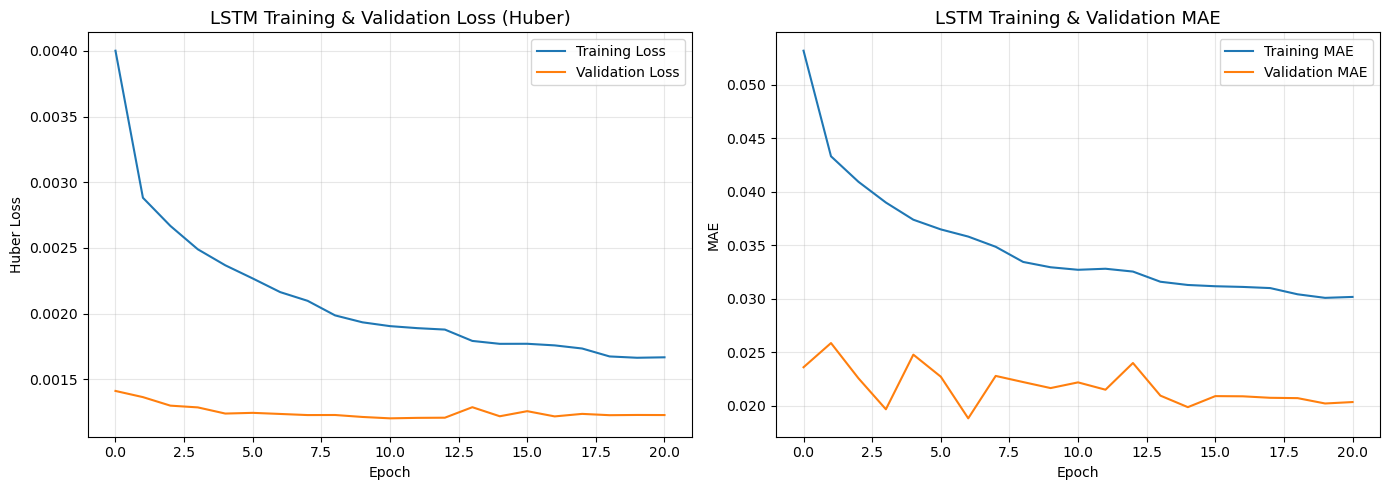

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('LSTM Training & Validation Loss (Huber)', fontsize=13)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Huber Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('LSTM Training & Validation MAE', fontsize=13)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

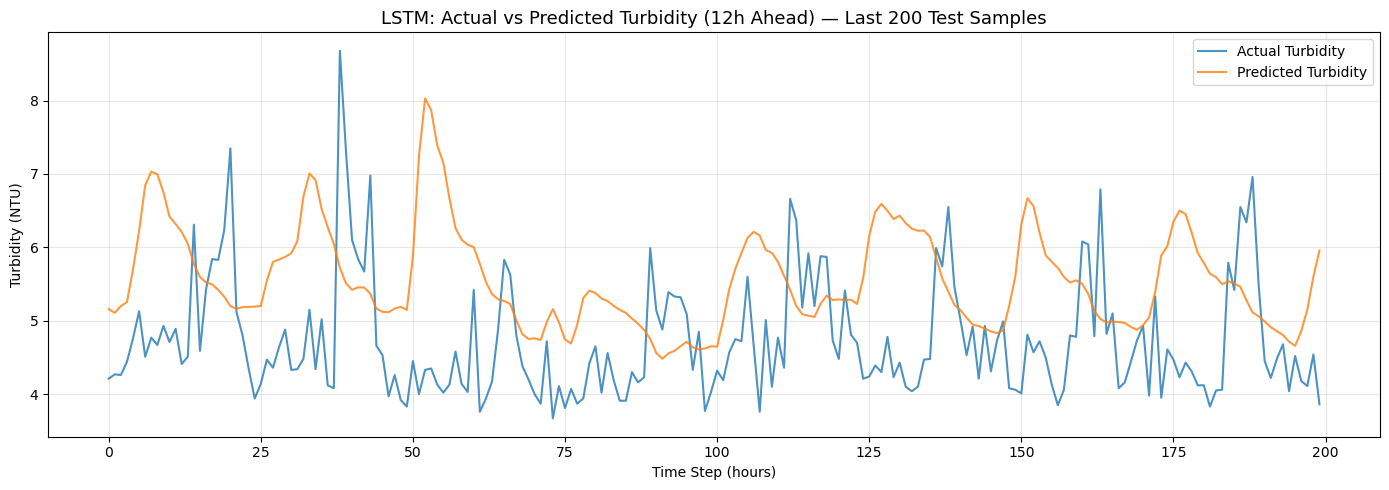

In [13]:
n_plot = 200
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(range(n_plot), y_test_inv[-n_plot:], label='Actual Turbidity', alpha=0.8, linewidth=1.5)
ax.plot(range(n_plot), y_pred_inv[-n_plot:], label='Predicted Turbidity', alpha=0.8, linewidth=1.5)
ax.set_title(f'LSTM: Actual vs Predicted Turbidity (12h Ahead) — Last {n_plot} Test Samples', fontsize=13)
ax.set_xlabel('Time Step (hours)')
ax.set_ylabel('Turbidity (NTU)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

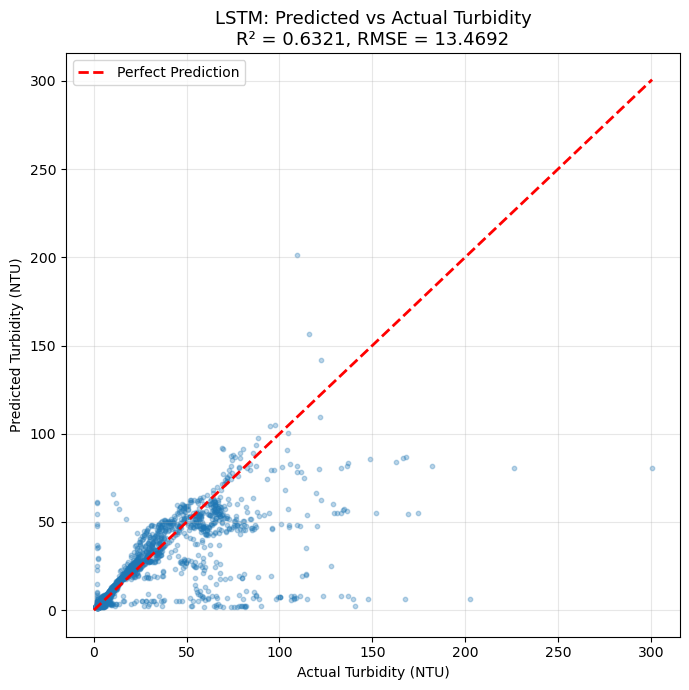

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(y_test_inv, y_pred_inv, alpha=0.3, s=10)
max_val = max(y_test_inv.max(), y_pred_inv.max())
ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Turbidity (NTU)')
ax.set_ylabel('Predicted Turbidity (NTU)')
ax.set_title(f'LSTM: Predicted vs Actual Turbidity\nR² = {r2:.4f}, RMSE = {rmse:.4f}', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

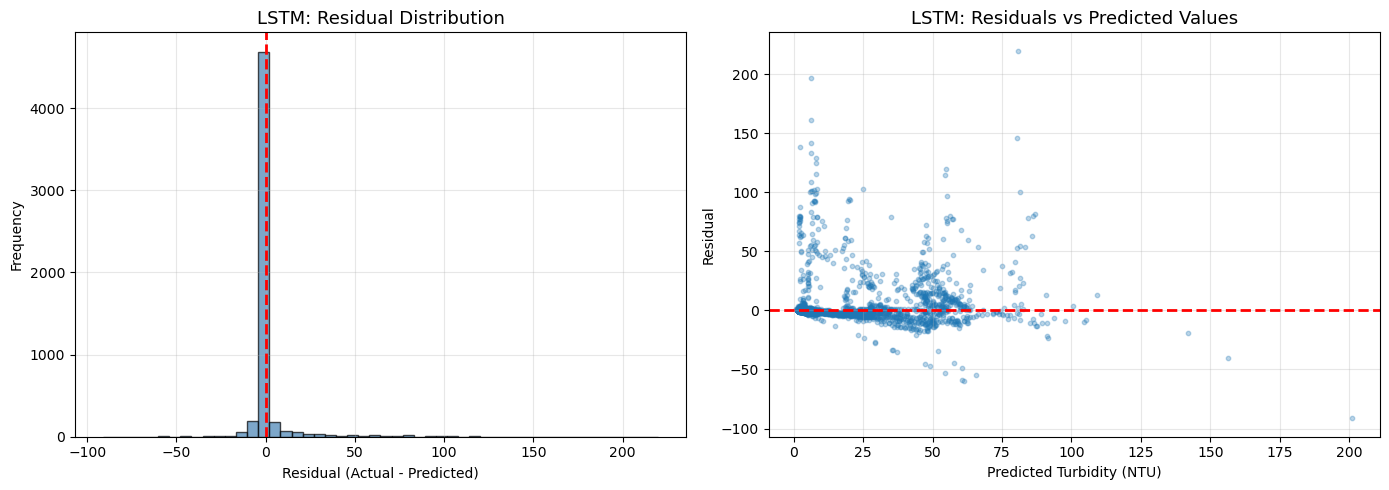

In [15]:
residuals = y_test_inv - y_pred_inv

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0].set_title('LSTM: Residual Distribution', fontsize=13)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_pred_inv, residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_title('LSTM: Residuals vs Predicted Values', fontsize=13)
axes[1].set_xlabel('Predicted Turbidity (NTU)')
axes[1].set_ylabel('Residual')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_residuals.png', dpi=150, bbox_inches='tight')
plt.show()

---
##  Model 2: Random Forest Classifier for Water Quality Status

###  Feature Selection

In [16]:
rf_features = [
    'Conductivity',                     # Sensor reading
    'Temp',                             # Sensor reading
    'Hour_sin',                         # Temporal encoding (sin)
    'Hour_cos',                         # Temporal encoding (cos)
    'Month_sin',                        # Temporal encoding (sin)
    'Month_cos',                        # Temporal encoding (cos)
    'IsWeekend',                        # Temporal feature
    'Conductivity_rolling_mean_6h',     # Rolling statistic
    'Conductivity_rolling_std_6h',      # Rolling statistic
    'Conductivity_lag_1h',              # Lag feature
    'Conductivity_lag_6h'               # Lag feature
]
target_col = 'Quality_Status'

print(f"11 Input Features:")
for i, f in enumerate(rf_features, 1):
    print(f"  {i:2d}. {f}")
print(f"\nTarget: {target_col}")

# Use ORIGINAL df (not log-transformed)
rf_df = df[rf_features + [target_col]].dropna().copy()
print(f"\nSamples after dropping nulls: {len(rf_df)}")
print(f"\nClass distribution:")
print(rf_df[target_col].value_counts())

X_rf = rf_df[rf_features].values
le = LabelEncoder()
y_rf = le.fit_transform(rf_df[target_col].values)
print(f"\nEncoded classes: {dict(zip(le.classes_, le.transform(le.classes_)))}")

11 Input Features:
   1. Conductivity
   2. Temp
   3. Hour_sin
   4. Hour_cos
   5. Month_sin
   6. Month_cos
   7. IsWeekend
   8. Conductivity_rolling_mean_6h
   9. Conductivity_rolling_std_6h
  10. Conductivity_lag_1h
  11. Conductivity_lag_6h

Target: Quality_Status

Samples after dropping nulls: 102276

Class distribution:
Quality_Status
Safe       44488
Warning    41856
Unsafe     15932
Name: count, dtype: int64

Encoded classes: {'Safe': np.int64(0), 'Unsafe': np.int64(1), 'Warning': np.int64(2)}


###  Train/Test Split

In [17]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf
)
print(f"Train set: {X_train_rf.shape[0]} samples")
print(f"Test set:  {X_test_rf.shape[0]} samples")

Train set: 81820 samples
Test set:  20456 samples


### Train Random Forest Classifier

In [18]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train_rf, y_train_rf)
print("Random Forest training complete!")

Random Forest training complete!


### Evaluation on Test Set

In [19]:
y_pred_rf = rf_model.predict(X_test_rf)
test_accuracy = accuracy_score(y_test_rf, y_pred_rf)

print("=" * 60)
print("RANDOM FOREST TEST SET RESULTS")
print("=" * 60)
print(f"  Accuracy: {test_accuracy:.4f}")
print("=" * 60)
print(f"\nClassification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=le.classes_))

RANDOM FOREST TEST SET RESULTS
  Accuracy: 0.8829

Classification Report:
              precision    recall  f1-score   support

        Safe       0.90      0.91      0.91      8898
      Unsafe       0.83      0.89      0.86      3186
     Warning       0.88      0.85      0.87      8372

    accuracy                           0.88     20456
   macro avg       0.87      0.88      0.88     20456
weighted avg       0.88      0.88      0.88     20456



###  Random Forest Visualizations

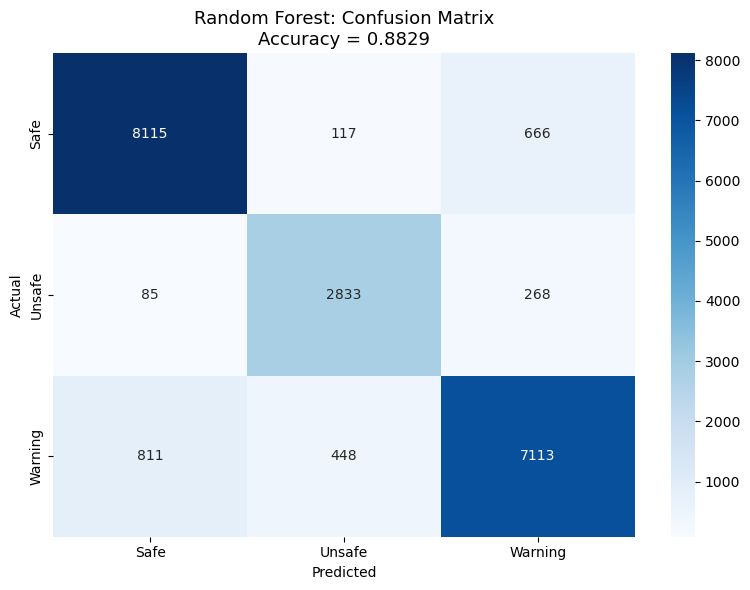

In [21]:
cm = confusion_matrix(y_test_rf, y_pred_rf)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_title(f'Random Forest: Confusion Matrix\nAccuracy = {test_accuracy:.4f}', fontsize=13)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

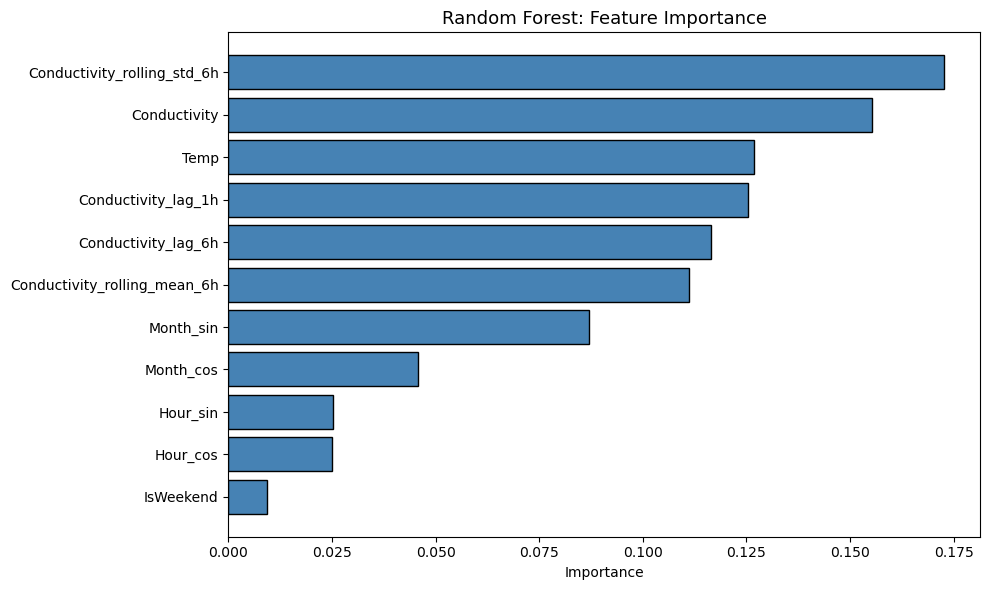

In [22]:
importances = rf_model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': rf_features,
    'Importance': importances
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='steelblue', edgecolor='black')
ax.set_title('Random Forest: Feature Importance', fontsize=13)
ax.set_xlabel('Importance')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

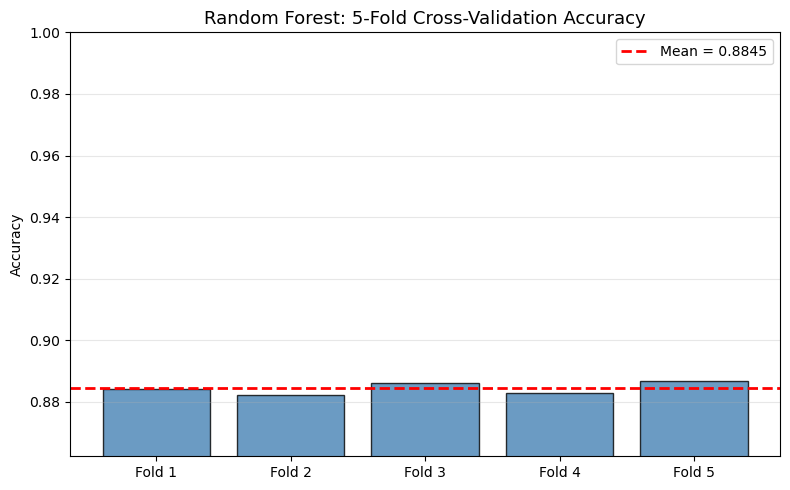

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
folds = [f'Fold {i+1}' for i in range(5)]
ax.bar(folds, cv_scores, color='steelblue', edgecolor='black', alpha=0.8)
ax.axhline(y=cv_scores.mean(), color='red', linestyle='--', lw=2, label=f'Mean = {cv_scores.mean():.4f}')
ax.set_ylim(min(cv_scores) - 0.02, 1.0)
ax.set_title('Random Forest: 5-Fold Cross-Validation Accuracy', fontsize=13)
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('rf_cross_validation.png', dpi=150, bbox_inches='tight')
plt.show()

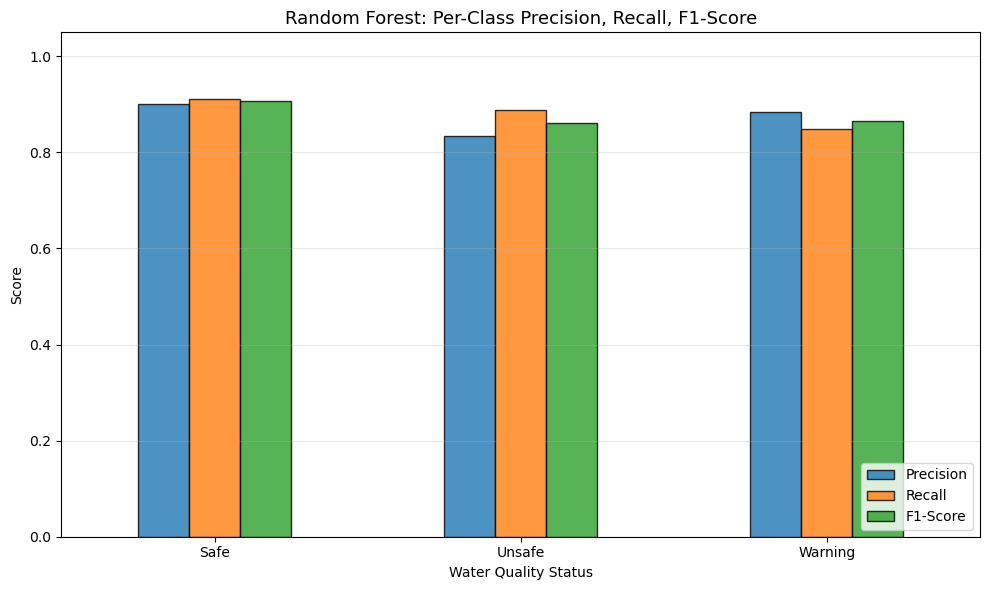

In [24]:
report_dict = classification_report(y_test_rf, y_pred_rf, target_names=le.classes_, output_dict=True)
class_metrics = pd.DataFrame({
    cls: {'Precision': report_dict[cls]['precision'],
          'Recall': report_dict[cls]['recall'],
          'F1-Score': report_dict[cls]['f1-score']}
    for cls in le.classes_
}).T

fig, ax = plt.subplots(figsize=(10, 6))
class_metrics.plot(kind='bar', ax=ax, edgecolor='black', alpha=0.8)
ax.set_title('Random Forest: Per-Class Precision, Recall, F1-Score', fontsize=13)
ax.set_ylabel('Score')
ax.set_xlabel('Water Quality Status')
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('rf_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

---
##  Final Summary

In [29]:
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)
print(f"""
Model 1: Improved Stacked LSTM (Deep Learning / Time Series)
  Architecture: LSTM(128) → Dropout(0.2) → LSTM(64) → Dropout(0.2) → Dense(32, ReLU) → Dense(1, Linear)
  Loss:    Huber (delta=1.0) — robust to outlier turbidity spikes
  Input:   {LOOKBACK}-hour lookback window, {len(FEATURES)} features
  Target:  Turbidity {HORIZON} hours ahead (log-transformed)
  Station: {best_station}
  
  Original-scale metrics:
    RMSE: {rmse:.4f} NTU
    MAE:  {mae:.4f} NTU
    R²:   {r2:.4f}
  
  Log-space metrics:
    RMSE: {rmse_log:.4f}
    MAE:  {mae_log:.4f}
    R²:   {r2_log:.4f}

Model 2: Random Forest Classifier
  Estimators: 200 | Max Depth: 20 | class_weight: balanced
  Input:   11 engineered features
  Target:  Water Quality Status (Safe / Warning / Unsafe)
  Test Accuracy:     {test_accuracy:.4f}

Both models predict DIFFERENT target variables:
  • LSTM → Turbidity (continuous, regression)
  • Random Forest → Quality Status (categorical, classification)
""")

FINAL SUMMARY

Model 1: Improved Stacked LSTM (Deep Learning / Time Series)
  Architecture: LSTM(128) → Dropout(0.2) → LSTM(64) → Dropout(0.2) → Dense(32, ReLU) → Dense(1, Linear)
  Loss:    Huber (delta=1.0) — robust to outlier turbidity spikes
  Input:   24-hour lookback window, 19 features
  Target:  Turbidity 12 hours ahead (log-transformed)
  Station: Sandy Ck Homebush
  
  Original-scale metrics:
    RMSE: 13.4692 NTU
    MAE:  3.7975 NTU
    R²:   0.6321
  
  Log-space metrics:
    RMSE: 0.4072
    MAE:  0.1965
    R²:   0.8354

Model 2: Random Forest Classifier
  Estimators: 200 | Max Depth: 20 | class_weight: balanced
  Input:   11 engineered features
  Target:  Water Quality Status (Safe / Warning / Unsafe)
  Test Accuracy:     0.8829

Both models predict DIFFERENT target variables:
  • LSTM → Turbidity (continuous, regression)
  • Random Forest → Quality Status (categorical, classification)

